# Аналитика в Яндекс.Афише

###   Необходимо оптимизировать маркетинговые затраты. Для этого проанализируем данные, посмторим отчеты, посчитаем метрики и посторим графики.

Загружаем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

1. [Прочитаем датасеты, проверим данные на пропуски и дупликаты, посмотрим тип данных](#step1)


2. [Продукт](#step2)
  
  2.1.[Посчитаем метрики](#step2.1)
   
   2.2.[Посчитаем Retention rate](#step2.2)
   
   2.3.[Вывод](#step2.3)


3. [Продажи](#step3)

  3.1 [Когда люди начинают покупать?](#step3.1)
  
  3.2 [Сколько раз покупают за период?](#step3.2)
  
  3.3 [Какой средний чек?](#step3.3)
  
  3.4 [Сколько денег приносят? (LTV)](#step3.4)
  
  3.5 [Вывод](#step3.5)
  

4. [Маркетинг](#step4)

  4.1 [Сколько денег потратили? Всего / на каждый источник / по времени](#step4.1)
  
  4.2 [Сколько стоило привлечение одного покупателя из каждого источника?](#step4.2)
  
  4.3 [На сколько окупились расходы? (ROI)](#step4.3)
  
  4.4 [Вывод](#step4.3)
  

5. [Общий вывод](#step5)

####  1. Прочитаем датасеты, проверим данные на пропуски и дупликаты, посмотрим тип данных  <a id="step1"></a>   

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()
visits.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


0

В датафрейме visits в данных нет пропусков и дупликатов.
Столбцы start_ts и end_ts имеют тип object, надо перевести их в дату.

In [4]:
orders.info()
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


0

В датафрейме orders в данных нет пропусков и дупликатов. Столбец Buy Ts имеет тип object, надо перевести его в дату.

In [5]:
costs.info()
costs.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


0

В датафрейме costs в данных нет пропусков и дупликатов. Столбец dt имеет тип object, надо перевести его в дату.

Изменим тип данных в датафреймах 

visits

In [6]:
visits.columns = visits.columns.str.lower() #приводим название столбцов к нижнему регистру
visits = visits.rename(columns={'end ts': 'end_ts', 'start ts': 'start_ts', 'source id': 'source_id'}) #заменим пробелы в названиях столбцов на подчеркивания

visits['start_ts']=pd.to_datetime(visits['start_ts'])
visits['end_ts']=pd.to_datetime(visits['end_ts'])

visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


orders

In [7]:
orders = orders.rename(columns={'Buy Ts':'buy_ts'})
orders.columns = orders.columns.str.lower()

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


costs

In [8]:
costs.head()
costs = costs.rename(columns={'dt':'date'}) #поменяем название столбца на date
costs['date'] = pd.to_datetime(costs['date'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### 2. Продукт <a id="step2"></a>  

Чтобы узнать - Сколько людей пользуются в день, неделю, месяц? Сколько сессий в день? Сколько длится одна сессия? Как часто люди возвращаются? - обратимся в датафрейму visits

In [9]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Добавим столбцы с датой сессии, номером недели, номером месяца, продолжительностью сессии в секундах

In [10]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year
visits['session_duration'] = visits['end_ts'] - visits['start_ts']
visits['session_duration'] = visits['session_duration'].dt.seconds / 60 #продолжительность сессии в минутах
visits['session_duration'] = visits['session_duration'].astype('int')

visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0


Посчитаем метрики DAU, WAU, MAU, ASL <a id="step2.1"></a>  

In [11]:
#Сколько людей пользуются в день
DAU = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
#Сколько людей пользуются в неделю
WAU = visits.groupby(['session_week','session_month','session_year']).agg({'uid': 'nunique'}).mean()
#Сколько людей пользуются в месяц
MAU =  visits.groupby(['session_month','session_year']).agg({'uid': 'nunique'}).mean()
#Cколько сессий в день 
SPD = visits.groupby('session_date').agg({'uid': 'count'}).mean()

print('в среднем пользователей в день', int(DAU))
print('в среднем пользователей в неделю',int(WAU))
print('в среднем пользователей в месяц',int(MAU))
print('в среднем в день',int(SPD),'сессий')

в среднем пользователей в день 907
в среднем пользователей в неделю 4911
в среднем пользователей в месяц 23228
в среднем в день 987 сессий


<font color="blue"> для WAU и MAU добавил группировку по году и месяцу </font> 

средняя продолжительность сессии 1 минута


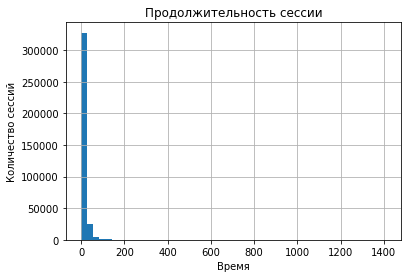

In [12]:
#Cколько длится одна сессия
visits['session_duration'].hist(bins=50)
plt.title('Продолжительность сессии')
plt.xlabel('Время')
plt.ylabel('Количество сессий')
ASL = visits['session_duration'].mode()
print('средняя продолжительность сессии',int(ASL), 'минута')

Посмотрим сколько сессий приходится на одного пользователя

In [13]:
users_sessions = visits.groupby('session_month').agg({'uid':['count','nunique']})
users_sessions.columns = ['n_sessions','n_users']
users_sessions['session_per_user'] = users_sessions['n_sessions'] / users_sessions['n_users']
users_sessions

,n_sessions,n_users,session_per_user
session_month,,,
1,36939,28716,1.286356
2,37182,28749,1.293332
3,35679,27473,1.298693
4,26515,21008,1.262138
5,26635,20701,1.286653
6,16505,13259,1.244815
7,17828,14183,1.256998
8,14355,11631,1.234202
9,23907,18975,1.259921


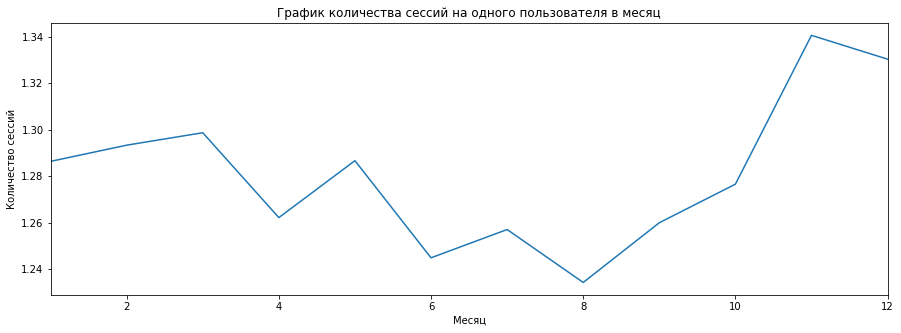

In [14]:
users_sessions['session_per_user'].plot(figsize=(15,5))
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.title('График количества сессий на одного пользователя в месяц')
plt.show()

В месяц один рользователь заходит в приложение меньше двух раз. Что довольно мало

In [15]:
#Регулярность использования приложения
sticky_wau = DAU / WAU * 100
sticky_mau = DAU / MAU * 100
print(int(sticky_wau),'% пользователей недельной аудитории повторно пользовались приложением')
print(int(sticky_mau),'% пользователей месячной аудитории повторно пользовались приложением')

18 % пользователей недельной аудитории повторно пользовались приложением
3 % пользователей месячной аудитории повторно пользовались приложением


Построим график с количеством визитов для разных устройств

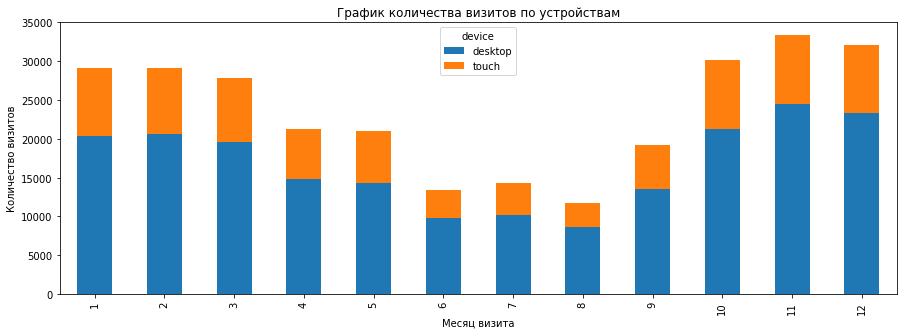

In [16]:
visits.pivot_table(index='session_month', columns='device', values='uid', aggfunc='nunique').plot(kind='bar',figsize=(15,5), 
            stacked=True)
plt.xlabel('Месяц визита')
plt.ylabel('Количество визитов')
plt.title('График количества визитов по устройствам')
plt.show()

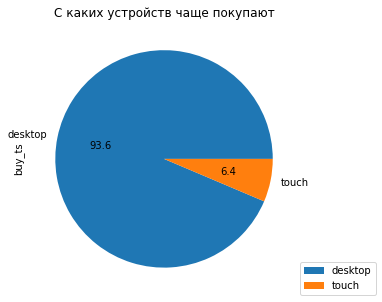

In [17]:
#Круговая диаграмма с каких устройств чаще покупают
orders_device=visits.merge(orders, on='uid', how='right')
orders_device.pivot_table(index='device', values='buy_ts', aggfunc='count').plot(kind='pie',
                                                                                 subplots=True, 
                                                                                 figsize=(10,5),
                                                                                 autopct='%.1f')
plt.title('C каких устройств чаще покупают')
plt.legend(loc=(1,0))
plt.show()

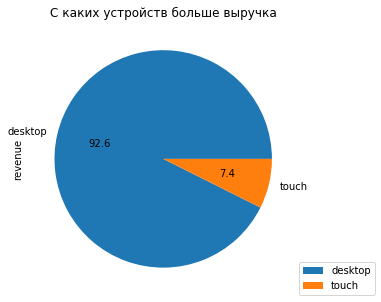

In [18]:
#Круговая диаграмма с каких устройств получили больше выручки
orders_device.pivot_table(index='device', values='revenue', aggfunc='sum').plot(kind='pie',
                                                                                 subplots=True, 
                                                                                 figsize=(10,5),
                                                                                 autopct='%.1f')
plt.title('C каких устройств больше выручка')
plt.legend(loc=(1,0))
plt.show()

С десктопов люди покупают чаще, чем с тач девайсов. И также с декстопов приходит болше выручки. 

С компьютера люди заходят чаще чем с телефона. Реже в приложение заходят в летние месяцы, предполложительно из-за сезона отпусков.

#### Как часто люди возвращаются?

Посчитаем Retention rate <a id="step2.2"></a>  

In [19]:
#Пересохраним данные в новый датафрейм
user_activity =visits[['uid','start_ts','source_id','device']]
#создаем объект series с датой первого использования приложения
first_activity_date = user_activity.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
#объеденим его с исходным датафреймом и сохраним в новый
user_activity = user_activity.join(first_activity_date, on='uid')
#переводим столбцы в формат даты
user_activity['activity_month'] = user_activity['start_ts'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')

user_activity.head()

,uid,start_ts,source_id,device,first_activity_date,activity_month,first_activity_month
0,16879256277535980062,2017-12-20 17:20:00,4,touch,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,104060357244891740,2018-02-19 16:53:00,2,desktop,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,7459035603376831527,2017-07-01 01:54:00,5,touch,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,16174680259334210214,2018-05-20 10:59:00,9,desktop,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,9969694820036681168,2017-12-27 14:06:00,3,desktop,2017-12-27 14:06:00,2017-12-01,2017-12-01


In [20]:
#Рассчитаем lifetime когорты
user_activity['cohort_lifetime'] = user_activity['activity_month'] - user_activity['first_activity_month']
#Переведем в месяц
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1,'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int')

In [21]:
#Найдем количество пользователей в каждом месяце
cohorts = user_activity.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [22]:
#Найдём исходное количество пользователей в когорте
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(inital_users_count,on='first_activity_month')

In [23]:
#Посчитаем Retention Rate
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту

In [24]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


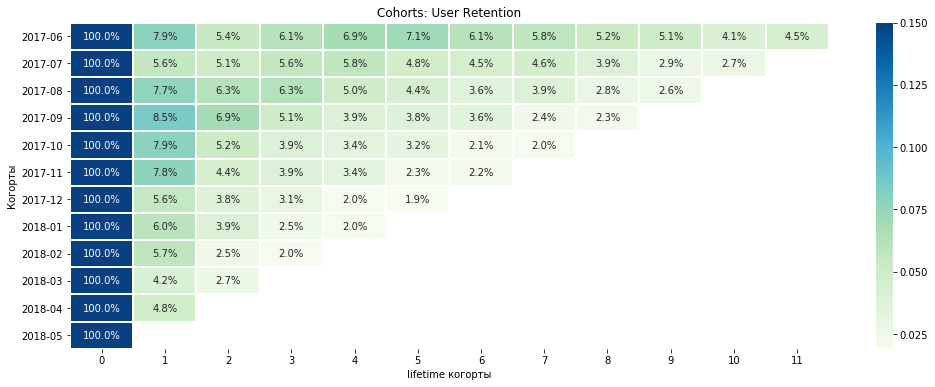

In [25]:
plt.figure(figsize=(17, 6))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, cmap='GnBu',vmax=0.15)
plt.xlabel('lifetime когорты')
plt.ylabel('Когорты')
ax.set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.show()

### Вывод <a id="step2.3"></a>  

Retention Rate пользователей приложения довольно низкий.На первый месяц жизни когороты остается от 4.2 до 8.5 % посетителей. С течением времени процент падает во всех когортах. Исключением являются июньская  когорта, у которых на 4й,5й,6й и 12й месяцы пользования retention вырос. Также в августовской когорте на 8й месяц retention тоже растет. 
Можно сделать вывод, что пользоватли из первой когорты чаще возвращаются, чем из последующих. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки.

Сколько людей пользуются в день, неделю, месяц?
в день 907
в неделю 5825
в месяц 23228

Сколько сессий в день?
987

Сколько длится одна сессия?
Продолжительность большей части сессий - от 0 до 2 минут

### 3. Продажи <a id="step3"></a>  

#### Когда люди начинают покупать? <a id="step3.1"></a>  

In [26]:
#Добавим в таблицу ordres колнку с датой первой активнсти
visits_orders = orders.merge(first_activity_date, on = 'uid')

In [27]:
#Найдем день первой покупки и добавим в таблицу visits_orders
first_order_date = visits_orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
visits_orders = visits_orders.merge(first_order_date, on = 'uid')
first_order_date.astype('datetime64[M]')

uid
313578113262317        2018-01-01
1575281904278712       2017-06-01
2429014661409475       2017-10-01
2464366381792757       2018-01-01
2551852515556206       2017-11-01
                          ...    
18445147675727495770   2017-11-01
18445407535914413204   2017-09-01
18445601152732270159   2018-03-01
18446156210226471712   2018-02-01
18446167067214817906   2017-10-01
Name: first_order_date, Length: 36523, dtype: datetime64[ns]

In [28]:
#Сгрупперуем по uid и найдем разницу между первым заходом и первой покупкой в минутах
first_buy_time = visits_orders.groupby('uid').agg({'first_order_date': 'min','first_activity_date': 'min'}).reset_index()
first_buy_time['first_buy_time'] = ((first_buy_time['first_order_date'] - first_buy_time['first_activity_date']) /
                           pd.Timedelta(1, unit='m')).astype(int)

In [29]:
first_buy_time['first_buy_time'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: first_buy_time, dtype: float64

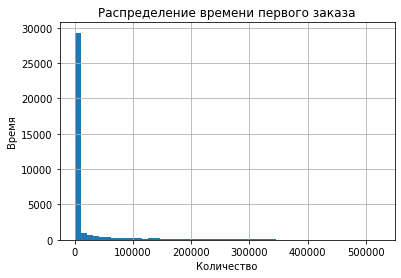

In [30]:
#Построим гистограмму
first_buy_time['first_buy_time'].hist(bins=50)
plt.title('Распределение времени первого заказа')
plt.xlabel('Количество')
plt.ylabel('Время')
plt.show()

In [31]:
#Разброс значений очень велик, поэтому возьмем медиану
print('Люди совершают покупку в среднем через {:.0f} минут.'
      .format((first_buy_time['first_buy_time']).median()))

Люди совершают покупку в среднем через 16 минут.


#### Сколько раз покупают за период? <a id="step3.2"></a>  

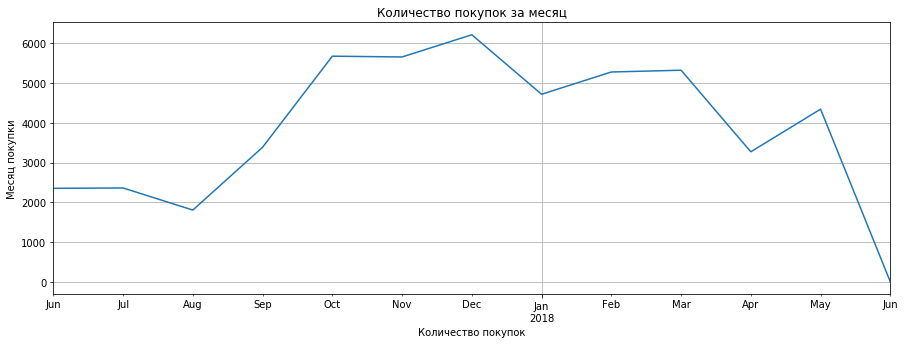

In [32]:
#Добавим столбец с месяцем 
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

#Построим график
orders.groupby('buy_month')['buy_ts'].count().plot(figsize=(15,5), grid=True)
plt.ylabel('Месяц покупки')
plt.xlabel('Количество покупок')
plt.title('Количество покупок за месяц')
plt.show()

Больше всего покупок было совершенно в декабре 17го. Меньше всего в летние месяцы 17го. Виден всплсек на май 18го, видимо покупали те, кто остался в городе на майские праздники.

In [33]:
#Добавим в таблицу дату и месяц первой покупки и месяц покупи
orders = orders.merge(first_order_date, on = 'uid')

orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [34]:
#Найдём количество заказов, покупателей и сумарную выручку
orders_cohorts = (orders.groupby(['first_order_month','order_month'])
                        .agg({'uid':['nunique','count'], 'revenue': 'sum'})
                        .reset_index())

orders_cohorts.columns = ['first_order_month','order_month','buyers_cnt','orders_cnt','revenue_sum']

In [35]:
#Выделим месячные когорты
orders_cohorts['cohort_lifetime'] = ((orders_cohorts['order_month'] - orders_cohorts['first_order_month']) / 
                                      np.timedelta64(1,'M')).round().astype(int)

In [36]:
#Найдём исходное количество пользователей в когорте
initial_buyers_count = orders_cohorts[orders_cohorts['cohort_lifetime'] == 0][['first_order_month', 'buyers_cnt']]
initial_buyers_count = initial_buyers_count.rename(columns = {'buyers_cnt': 'cohort_buyer_cnt'})

orders_cohorts = orders_cohorts.merge(initial_buyers_count, on='first_order_month')

In [37]:
#Найдём сколько покупок приходится на одного покупателя
orders_cohorts['order_per_user'] = orders_cohorts['orders_cnt'] / orders_cohorts['buyers_cnt']

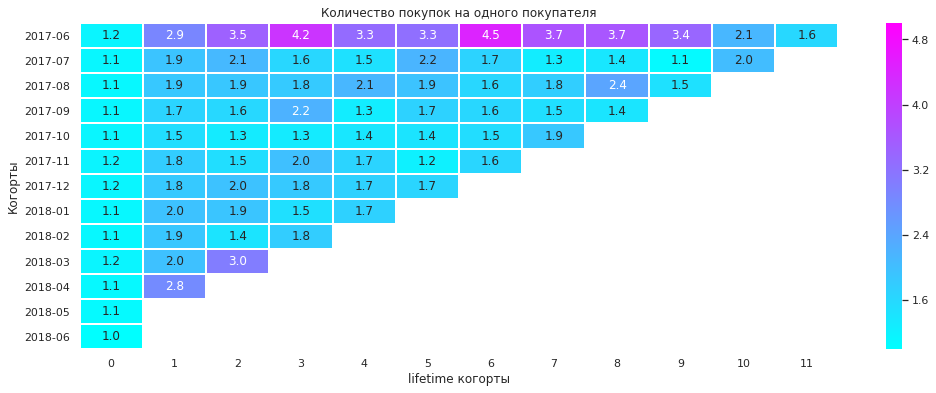

In [38]:
#Построим тепловую карту
order_per_user_pivot = orders_cohorts.pivot_table(index = 'first_order_month',
                                                  columns = 'cohort_lifetime',
                                                  values = 'order_per_user',
                                                  aggfunc = 'mean')
plt.figure(figsize=(17, 6))
sns.set(style='white')
plt.title('Количество покупок на одного покупателя')
ax = sns.heatmap(order_per_user_pivot, annot=True, fmt='.1f', vmax=5, linewidths=1, linecolor='white', cmap='cool')
plt.xlabel('lifetime когорты')
plt.ylabel('Когорты')
ax.set_yticklabels(order_per_user_pivot.index.strftime('%Y-%m'))
plt.show()

Во всех когортах после первого месяца возрастает количество покупок примерно в 1,5-2 раза, люди продолжают пользоваться сервисом. Наиболее активно совершают покупки пользователи из первой когорты.

#### Какой средний чек? <a id="step3.3"></a>  

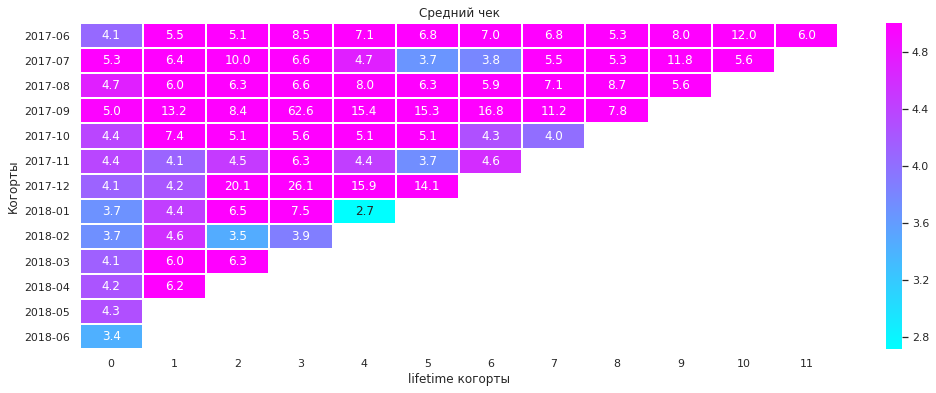

In [39]:
#Посмотрим средний чек для когорт
orders_cohorts['revenue_per_order'] = orders_cohorts['revenue_sum'] / orders_cohorts['orders_cnt']

revenue_per_order_pivot= orders_cohorts.pivot_table(index='first_order_month', 
                                                       columns='cohort_lifetime', 
                                                       values='revenue_per_order',
                                                       aggfunc='mean')
plt.figure(figsize=(17,6))
plt.title('Средний чек')
ax=sns.heatmap(revenue_per_order_pivot, annot=True, fmt='.1f', vmax=5, linewidth=1, linecolor='white', cmap='cool')
plt.xlabel('lifetime когорты')
plt.ylabel('Когорты')
ax.set_yticklabels(revenue_per_order_pivot.index.strftime('%Y-%m'))
plt.show()

In [40]:
orders['revenue'].mean() #Общий средний чек

4.999646930477041

Средний чек по всем продажам равен 4.99. В среднем средние чеки у всех когорт примерно одинаковы. Выделяются сентябрьская когорта и декабрьская. Возможно в эти месяцы проводились какиe-то крупные мероприятия.

#### Сколько денег приносят? (LTV) <a id="step3.4"></a>  

In [41]:
#Установим маржинальность
margin_rate = 0.5 
orders_cohorts.head()

,first_order_month,order_month,buyers_cnt,orders_cnt,revenue_sum,cohort_lifetime,cohort_buyer_cnt,order_per_user,revenue_per_order
0,2017-06-01,2017-06-01,2023,2354,9557.49,0,2023,1.163618,4.060106
1,2017-06-01,2017-07-01,61,177,981.82,1,2023,2.901639,5.547006
2,2017-06-01,2017-08-01,50,174,885.34,2,2023,3.480000,5.088161
3,2017-06-01,2017-09-01,54,226,1931.30,3,2023,4.185185,8.545575
4,2017-06-01,2017-10-01,88,292,2068.58,4,2023,3.318182,7.084178


In [42]:
orders_cohorts['gp'] = orders_cohorts['revenue_sum'] * margin_rate #Валовая прибыль
orders_cohorts['ltv'] = orders_cohorts['gp'] / orders_cohorts['buyers_cnt'] #Сколько в среднем приносит один клиент за месяц
orders_cohorts.head()

,first_order_month,order_month,buyers_cnt,orders_cnt,revenue_sum,cohort_lifetime,cohort_buyer_cnt,order_per_user,revenue_per_order,gp,ltv
0,2017-06-01,2017-06-01,2023,2354,9557.49,0,2023,1.163618,4.060106,4778.745,2.362207
1,2017-06-01,2017-07-01,61,177,981.82,1,2023,2.901639,5.547006,490.910,8.047705
2,2017-06-01,2017-08-01,50,174,885.34,2,2023,3.480000,5.088161,442.670,8.853400
3,2017-06-01,2017-09-01,54,226,1931.30,3,2023,4.185185,8.545575,965.650,17.882407
4,2017-06-01,2017-10-01,88,292,2068.58,4,2023,3.318182,7.084178,1034.290,11.753295


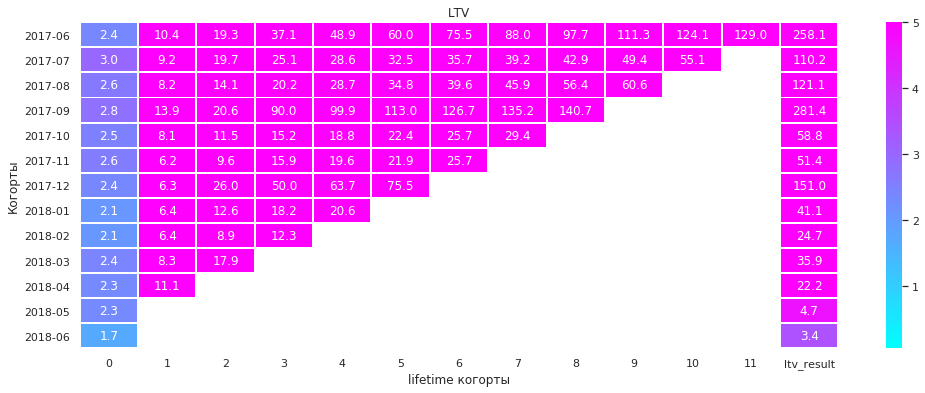

In [43]:
ltv_pivot = orders_cohorts.pivot_table(index='first_order_month',
                                       columns = 'cohort_lifetime',
                                       values = 'ltv',
                                       aggfunc = 'mean')
ltv_pivot['ltv_result'] = ltv_pivot.sum(1)

plt.figure(figsize=(17,6))
plt.title('LTV')
ax=sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, fmt='.1f', vmax=5,vmin=0.05, linewidth=1, linecolor='white', cmap='cool')
plt.xlabel('lifetime когорты')
plt.ylabel('Когорты')
ax.set_yticklabels(revenue_per_order_pivot.index.strftime('%Y-%m'))
plt.show()

#### Вывод <a id="step3.5"></a>  

Июньская и сентябрьская когорты лидируют по показателю LTV.
Люди совершают покупку в среднем через 16 минут.
Больше всего покупок было совершенно в декабре 17го. Меньше всего в летние месяцы 17го.
Во всех когортах после первого месяца возрастает количество покупок примерно в 1,5-2 раза.
Средний чек по всем продажам равен 4.99. В среднем средние чеки у всех когорт примерно одинаковы. 

### 4. Маркетинг <a id="step4"></a>  

#### Сколько денег потратили? Всего / на каждый источник / по времени <a id="step4.1"></a>  

In [44]:
#Всего
print('Всего было потрачено', costs['costs'].sum())

Всего было потрачено 329131.62


In [45]:
#На каждый источник
source_costs = costs.pivot_table(index='source_id', values='costs', aggfunc='sum')
source_costs

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


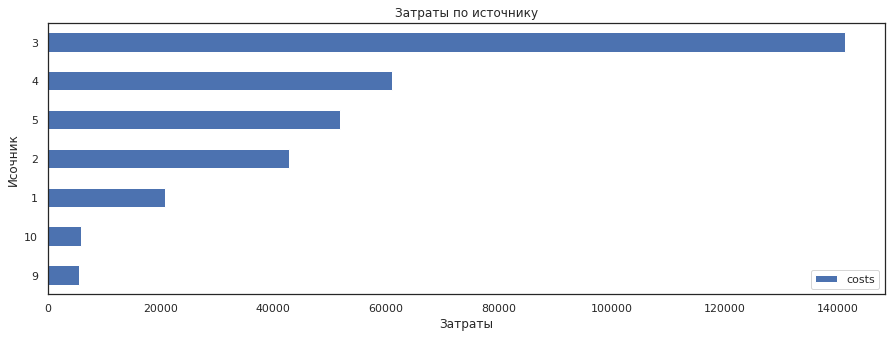

In [46]:
#График затрат по источникам
source_costs.sort_values('costs').plot(kind='barh', figsize=(15,5))
plt.title('Затраты по источнику')
plt.xlabel('Затраты')
plt.ylabel('Исочник')
plt.show()

In [47]:
#Посмотрим из какого источника был первый визит и сколько людей оттуда пришил
first_visits_source = (visits.sort_values(by = ['start_ts'], ascending = True)
                             .groupby('uid').agg({'source_id': 'first'}).reset_index()
                             .groupby('source_id').agg({'uid': 'count'})).reset_index()
first_visits_source

,source_id,uid
0,1,9469
1,2,17616
2,3,66116
3,4,72346
4,5,49237
5,6,2
6,7,32
7,9,6448
8,10,6903


На 3й источник было потрачено больше всего 141321. Меньше всего на 9й - 5517. 
6го, 7го и 8го в результирующей таблице нет - на них бюджет не выделялся.
4й источник привлек больше всего людей - 72346

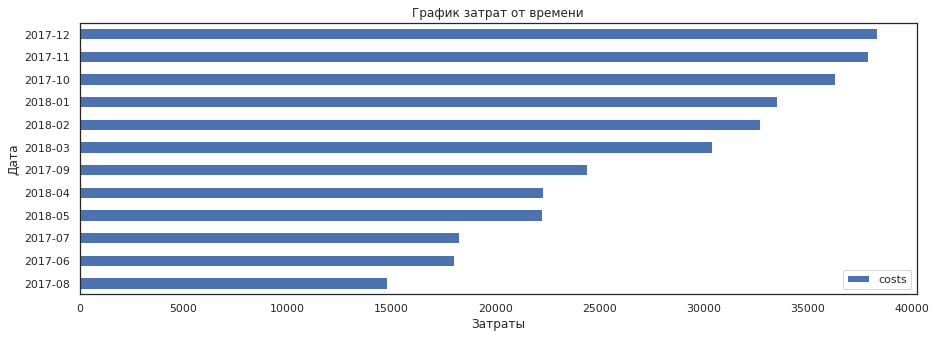

In [48]:
#По времени
costs['month_cost'] = costs['date'].astype('datetime64[M]')
time_costs = costs.pivot_table(index='month_cost', values='costs', aggfunc='sum').sort_values('costs')
time_costs.plot(kind='barh', figsize=(15,5)).set_yticklabels(time_costs.index.strftime('%Y-%m'))
plt.title('График затрат от времени')
plt.xlabel('Затраты')
plt.ylabel('Дата')
plt.show()

In [49]:
time_costs

,costs
month_cost,
2017-08-01,14790.54
2017-06-01,18015.00
2017-07-01,18240.59
2018-05-01,22224.27
2018-04-01,22289.38
2017-09-01,24368.91
2018-03-01,30415.27
2018-02-01,32723.03
2018-01-01,33518.52


в 17м году с октября по декабрь были самые большие затраты.

#### Сколько стоило привлечение одного покупателя из каждого источника? <a id="step4.2"></a> 

In [50]:
#Дата первой покупки
v6=orders.groupby(['uid','buy_ts']).agg({'revenue':'sum'}).reset_index()
v6['buy_ts']=v6['buy_ts'].astype('datetime64[M]')
v6.columns=['uid','buy_month','revenue']
v6.head()

,uid,buy_month,revenue
0,313578113262317,2018-01-01,0.55
1,1575281904278712,2017-06-01,1.22
2,1575281904278712,2017-06-01,1.83
3,2429014661409475,2017-10-01,73.33
4,2464366381792757,2018-01-01,2.44


In [51]:
#Источник первого визита
v61=visits.groupby('uid').agg({'start_ts':'min','source_id':'first'}).reset_index().rename(columns={'start_ts':'first_visit_month'})
v61['first_visit_month']=v61['first_visit_month'].astype('datetime64[M]')
v61.head()

,uid,first_visit_month,source_id
0,11863502262781,2018-03-01,3
1,49537067089222,2018-02-01,2
2,297729379853735,2017-06-01,3
3,313578113262317,2017-09-01,2
4,325320750514679,2017-09-01,5


In [52]:
#Месяц первой покупки
v62=pd.merge(v61,v6,on='uid')
v612=v62[['uid','buy_month','source_id']].drop_duplicates()
v612=v612.groupby(['uid','source_id']).agg({'buy_month':'min'}).reset_index().rename(columns={'buy_month':'first_buy_month'})
v612.head()

,uid,source_id,first_buy_month
0,313578113262317,2,2018-01-01
1,1575281904278712,10,2017-06-01
2,2429014661409475,3,2017-10-01
3,2464366381792757,5,2018-01-01
4,2551852515556206,5,2017-11-01


In [53]:
#Количество новых покупателей
v63=v612.groupby(['first_buy_month','source_id']).agg({'uid':'nunique'}).reset_index().rename(columns={'uid':'n_buyers'})
v63.head()

,first_buy_month,source_id,n_buyers
0,2017-06-01,1,203
1,2017-06-01,2,271
2,2017-06-01,3,574
3,2017-06-01,4,417
4,2017-06-01,5,368


In [54]:
#Таблица с группировкой по месяцу первой покупки, источкнику и суммой выручкии
v622=v62[['uid','source_id','buy_month','revenue']]
v622=pd.merge(v622,v612,on=['uid','source_id'])
v623=v622.groupby(['first_buy_month','buy_month','source_id']).agg({'revenue':'sum'}).reset_index()
v623.head()

,first_buy_month,buy_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1168.45
1,2017-06-01,2017-06-01,2,1551.76
2,2017-06-01,2017-06-01,3,2466.71
3,2017-06-01,2017-06-01,4,2039.64
4,2017-06-01,2017-06-01,5,1787.68


In [55]:
v64=pd.merge(v63,v623,on=['first_buy_month','source_id'])
v64.head()

,first_buy_month,source_id,n_buyers,buy_month,revenue
0,2017-06-01,1,203,2017-06-01,1168.45
1,2017-06-01,1,203,2017-07-01,362.94
2,2017-06-01,1,203,2017-08-01,153.72
3,2017-06-01,1,203,2017-09-01,695.88
4,2017-06-01,1,203,2017-10-01,760.74


In [56]:
monthly_cost=costs.groupby(['month_cost','source_id'])['costs'].sum().reset_index().rename(columns={'month_cost':'buy_month'})
monthly_cost['buy_month']=monthly_cost['buy_month'].dt.strftime('%Y-%m')
monthly_cost.head()

,buy_month,source_id,costs
0,2017-06,1,1125.61
1,2017-06,2,2427.38
2,2017-06,3,7731.65
3,2017-06,4,3514.80
4,2017-06,5,2616.12


In [57]:
v7_report=v64
v7_report['first_buy_month']=v7_report['first_buy_month'].astype('datetime64[M]')
v7_report['buy_month']=v7_report['buy_month'].astype('datetime64[M]')
v7_report.head()

,first_buy_month,source_id,n_buyers,buy_month,revenue
0,2017-06-01,1,203,2017-06-01,1168.45
1,2017-06-01,1,203,2017-07-01,362.94
2,2017-06-01,1,203,2017-08-01,153.72
3,2017-06-01,1,203,2017-09-01,695.88
4,2017-06-01,1,203,2017-10-01,760.74


In [58]:
v7_report['gp']=v7_report['revenue']*margin_rate
v7_report['age']=(v7_report['buy_month']-v7_report['first_buy_month'])/np.timedelta64(1,'M')
v7_report['age']=v7_report['age'].round().astype('int')
v7_report['ltv']=v7_report['gp']/v7_report['n_buyers']
v7_report.head()

,first_buy_month,source_id,n_buyers,buy_month,revenue,gp,age,ltv
0,2017-06-01,1,203,2017-06-01,1168.45,584.225,0,2.877956
1,2017-06-01,1,203,2017-07-01,362.94,181.470,1,0.893941
2,2017-06-01,1,203,2017-08-01,153.72,76.860,2,0.378621
3,2017-06-01,1,203,2017-09-01,695.88,347.940,3,1.713990
4,2017-06-01,1,203,2017-10-01,760.74,380.370,4,1.873744


In [59]:
monthly_cost['buy_month']=monthly_cost['buy_month'].astype('datetime64[M]')
monthly_cost.columns=['first_buy_month','source_id','costs']
monthly_cost.head()

,first_buy_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [60]:
#Добавляем в таблицу САС и ROMI
report_new=v7_report.merge(monthly_cost,on=['source_id','first_buy_month'])
report_new['cac']=report_new['costs']/report_new['n_buyers']
report_new['romi']=report_new['ltv']/report_new['cac']
report_new.head()

,first_buy_month,source_id,n_buyers,buy_month,revenue,gp,age,ltv,costs,cac,romi
0,2017-06-01,1,203,2017-06-01,1168.45,584.225,0,2.877956,1125.61,5.544877,0.519030
1,2017-06-01,1,203,2017-07-01,362.94,181.470,1,0.893941,1125.61,5.544877,0.161219
2,2017-06-01,1,203,2017-08-01,153.72,76.860,2,0.378621,1125.61,5.544877,0.068283
3,2017-06-01,1,203,2017-09-01,695.88,347.940,3,1.713990,1125.61,5.544877,0.309112
4,2017-06-01,1,203,2017-10-01,760.74,380.370,4,1.873744,1125.61,5.544877,0.337923


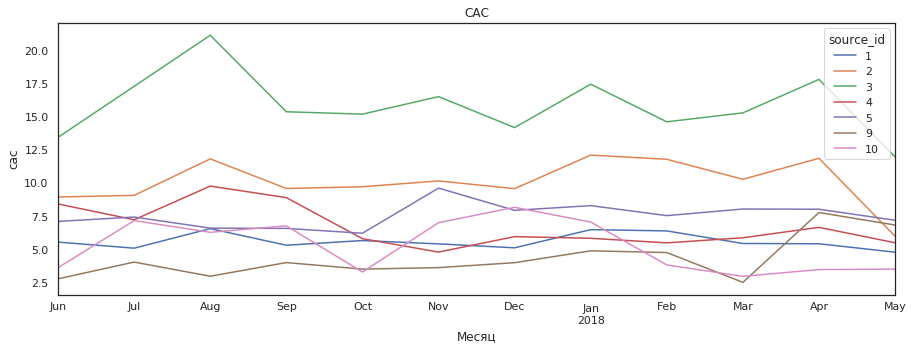

In [61]:
report_pivot=report_new.pivot_table(index='first_buy_month',columns='source_id',values='cac')
report_pivot.plot(figsize=(15,5))
plt.title('CAC')
plt.xlabel('Месяц')
plt.ylabel('cac')
plt.show()

In [67]:
#Средний САС по источникам
report_new2=report_new.groupby('source_id').agg({'n_buyers': 'sum', 'costs':'sum'}).reset_index()

In [69]:
report_new2['cac']=report_new2['costs']/report_new2['n_buyers']
report_new2

,source_id,n_buyers,costs,cac
0,1,22844,127585.19,5.585063
1,2,26403,263847.09,9.993072
2,3,55323,868903.37,15.706006
3,4,57666,378008.44,6.555135
4,5,42875,317923.30,7.415121
5,9,8905,32658.70,3.667456
6,10,4971,24553.91,4.939431


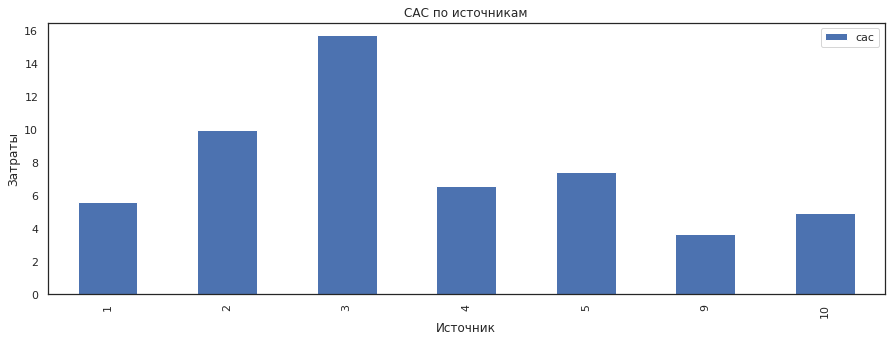

In [73]:
report_new2.pivot_table(index='source_id', values='cac').plot(kind='bar', figsize=(15, 5))
plt.title('САС по источникам')
plt.xlabel('Источник')
plt.ylabel('Затраты')
plt.show()

In [77]:
#Окупаемость источников
report_new3=report_new.groupby(['first_buy_month','source_id']).agg({'ltv': 'sum'}).reset_index()
report_new4=report_new3.groupby('source_id').agg({'ltv':'mean'}).reset_index()
report_new4

,source_id,ltv
0,1,5.747309
1,2,7.597323
2,3,2.478050
3,4,2.841848
4,5,3.111648
5,9,2.672613
6,10,1.721611


In [80]:
report_new5=pd.merge(report_new2,report_new4, on='source_id')
report_new5['romi']=report_new5['ltv']/report_new5['cac']
report_new5

,source_id,n_buyers,costs,cac,ltv,romi
0,1,22844,127585.19,5.585063,5.747309,1.029050
1,2,26403,263847.09,9.993072,7.597323,0.760259
2,3,55323,868903.37,15.706006,2.478050,0.157777
3,4,57666,378008.44,6.555135,2.841848,0.433530
4,5,42875,317923.30,7.415121,3.111648,0.419635
5,9,8905,32658.70,3.667456,2.672613,0.728738
6,10,4971,24553.91,4.939431,1.721611,0.348544


In [87]:
print('Всего потратили - ', int(report_new['costs'].sum()))

Всего потратили -  2013480


Полностью окупается только 1й источник. 

За ним идут 2й и 9й

Самые большие затраты были на 3й источник

#### На сколько окупились расходы?
Рассчитаем ROMI

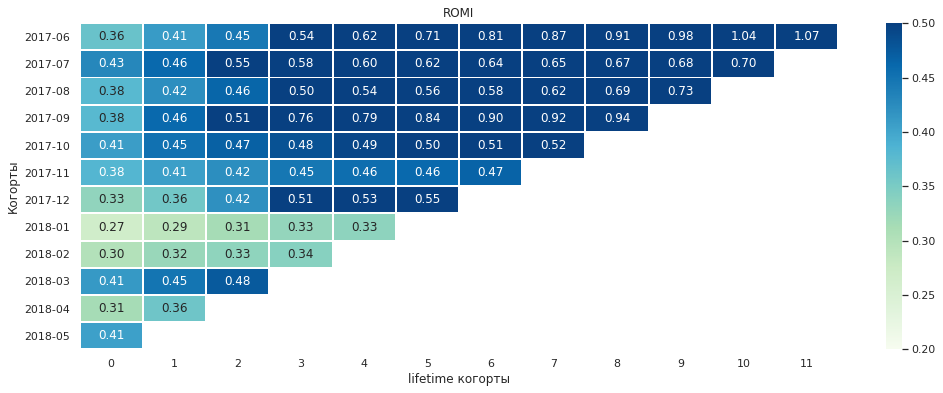

In [66]:
romi = report_new.pivot_table(index = 'first_buy_month',
                                        columns = 'age',
                                        values = 'romi',
                                        aggfunc = 'mean')
plt.figure(figsize=(17,6))
plt.title('ROMI')
ax=sns.heatmap(romi.cumsum(axis=1), annot=True, fmt='.2f', vmax=0.5, vmin=0.2, linewidth=1, linecolor='white', cmap='GnBu')
plt.xlabel('lifetime когорты')
plt.ylabel('Когорты')
ax.set_yticklabels(romi.index.strftime('%Y-%m'))
plt.show()

Только июньская когорта окупилась на 10й месяц


#### Вывод <a id="step4.4"></a> 



На 3й источник было потрачено больше всего - 868903.

Меньше всего на 9й - 32658.  4й источник привлек больше всего людей - 57666

3й источник оказался самым дорогим по стоимости привлечения клиента - 15.7

9й источник оказался самым дешевым - 3.66 





Только июньская когорта окупилась на 10й месяц

### 5. Общий вывод <a id="step5"></a> 

Сервисом Яндекс-Афиша люди предпочитают в 2,5 раза больше с desktop устройств, чем с touch устиройств.
Наиболее актвно сервисои пользуются с ноября по март. Сессия в среднем длится 1 минуту, а первую покупку совершают, через 16 мин после первого захода.

Источники:

3й и 2й  источник самые дорогие в привлечении одного клиента. Расходы на эти источники стоит сократить или убрать.

Полностью окупился только 1й источник. Также источники 2 и 9 близки к окупаемости - их romi 0,76 и 0,72 соответсвенно.
Я бы рекомендовал маркетологам обратить внимание именно на них.


Средний чек по всем продажам равен 4.99. Выделяются сентябрьская когорта и декабрьская - у них средний чек больше. Возможно в эти месяцы проводились какиe-то крупные мероприятия.

Больше всего покупок было совершенно в декабре 17го. Меньше всего в летние месяцы 17го. Виден всплсек на май 18го, видимо покупали те, кто остался в городе на майские праздники.

Коэффициент удержания:

Retention Rate в первый месяц убывает по когортам с течением времени. Если для когорты пользователей, пришедших в июне 2017 Retention Rate в первый месяц составляет 7,9%, то для пользователей, пришедших в апреле 2018 — уже 4,8%. Так, за 11 месяцев коэффициент удержания упал на 3,1%. Это говорит, что с каждой новой когортой поведение покупателей меняется. Возможно, были выбраны неэффективные источники трафика.

Сколько людей пользуются в день, неделю, месяц? в день 907 в неделю 5825 в месяц 23228

Сколько сессий в день? 987

Сколько длится одна сессия? Продолжительность большей части сессий - от 0 до 2 минут